In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Import stationarity test libraries to evaluate a time series
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

import math
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

import warnings
warnings.filterwarnings('ignore')

Formatting data

In [ ]:
# Read data
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
# Count total monthly number of passengers
data['Month']=data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]),15))     # sets date format into YYYY-MM-15

# Set the index to Month
data = data.set_index('Month')
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


Time Series Analysis

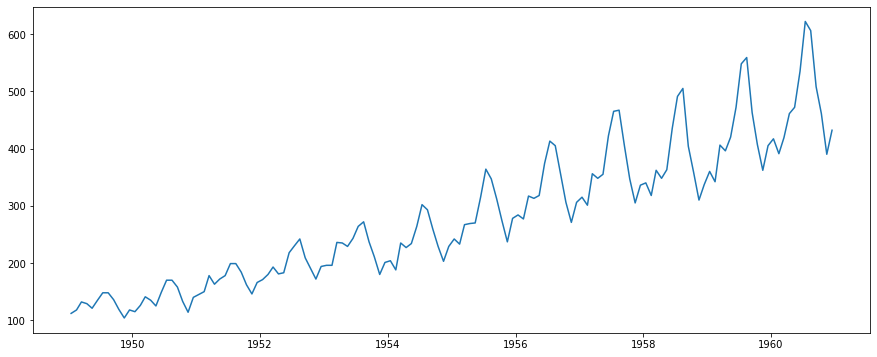

In [ ]:
# Assign the passengers data time series variable
ts = data['#Passengers']

# Plot the time series we get
plt.plot(ts)                      # increasing trend w/seasonality

In [ ]:
# Transform series using log decomposition
ts_log = np.log(ts)

In [ ]:
# Stationarity check - functions for rolling statistics and Dickey-Fuller Test
def test_stationarity(timeseries):

  # Rolling average and standard deviation
  rolmean = timeseries.rolling(window=52,center=False).mean()
  rolstd = timeseries.rolling(window=52,center=False).std()

  # Plot rolling statistics
  orig = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show(block=False)

  # Dickey-Fuller test
  print('Results of the Dickey-Fuller test')
  dftest = adfuller(timeseries,autolag='AIC')

  # P-value and other test statistics
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

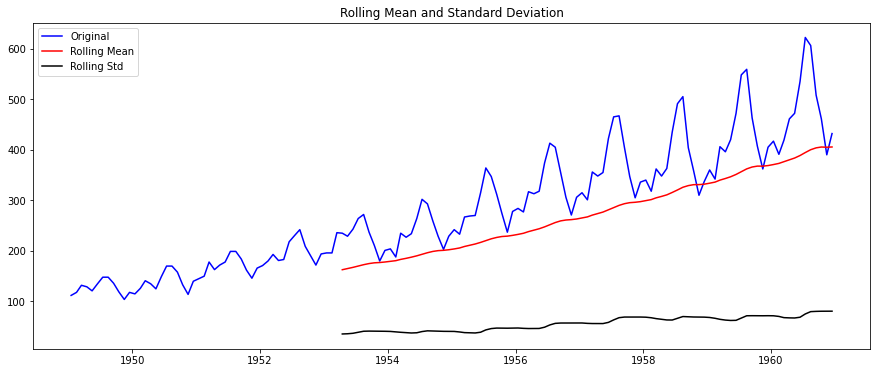

Results of the Dickey-Fuller test
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
# Perform stationarity checks
test_stationarity(data['#Passengers'])

# Moving Average is not constant over time
# Null Hypothesis of the Dickey Fuller test cannot be rejected
# Non-Stationary Time Series

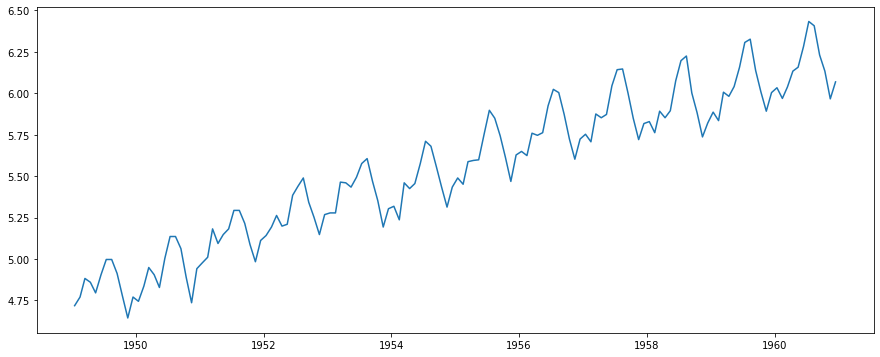

In [ ]:
# Decompose the data
plt.plot(ts_log)

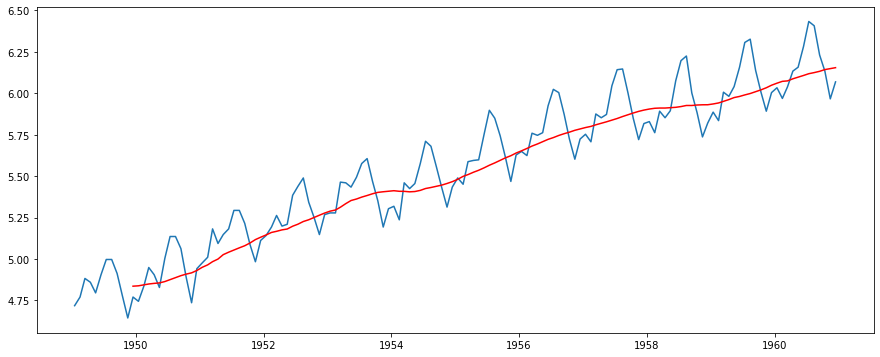

In [ ]:
# Define moving average and standard deviation - 12-month time window
movingAverage = ts_log.rolling(window=12).mean()
movingSTD = ts_log.rolling(window=12).std()

# Plot moving average
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [ ]:
# Define the difference between the the time series and its moving average
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)                     # First 12 values

Month
1949-01-15         NaN
1949-02-15         NaN
1949-03-15         NaN
1949-04-15         NaN
1949-05-15         NaN
1949-06-15         NaN
1949-07-15         NaN
1949-08-15         NaN
1949-09-15         NaN
1949-10-15         NaN
1949-11-15         NaN
1949-12-15   -0.065494
Name: #Passengers, dtype: float64

In [ ]:
# Drop null values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(10)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
Name: #Passengers, dtype: float64

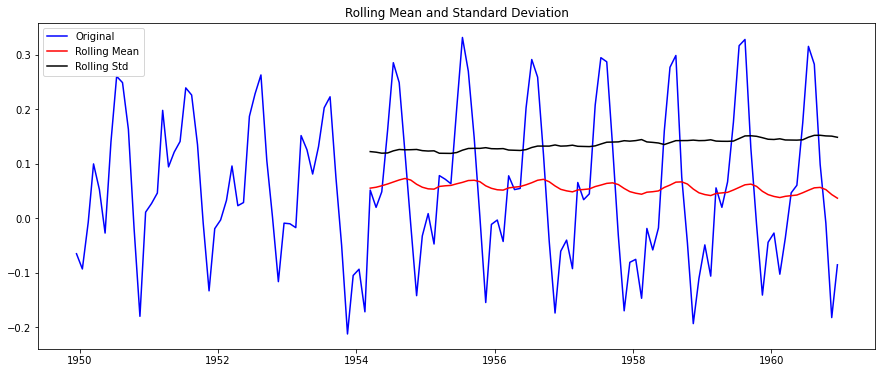

Results of the Dickey-Fuller test
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
# Parse time series data and check for stationarity
test_stationarity(ts_log_mv_diff)

# Stationary series
# Reject the null hypothesis

**Part 2**





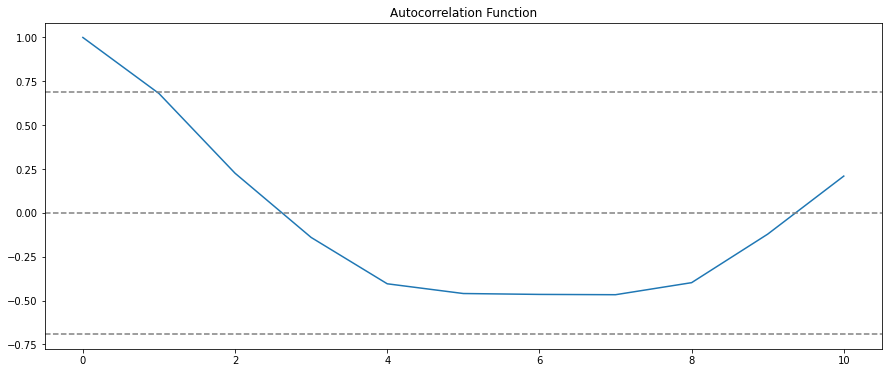

In [ ]:
# Plot ACF
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.show()

# Upper confidence when the lag value is between 0 and 1 
# The optimal value of q and ARIMA model must be 0 or 1 

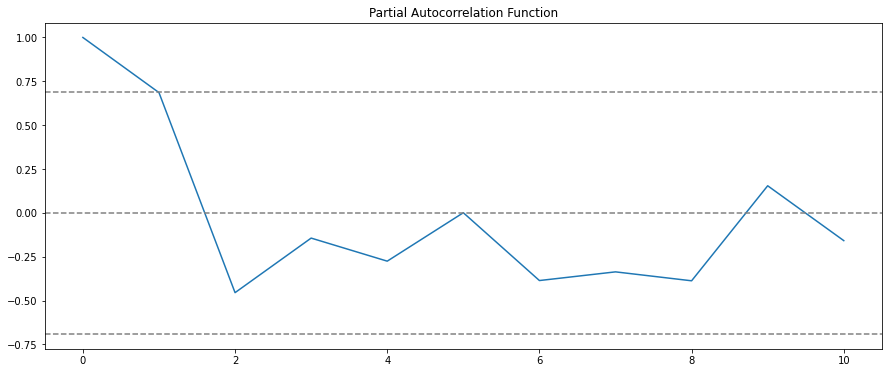

In [ ]:
# Plot PACF
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags=10))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

# PACF drops to 0 between lag values of 1 and 2
# The optimal value of p is 1 or 2

Text(0.5, 1.0, 'RSS: nan')

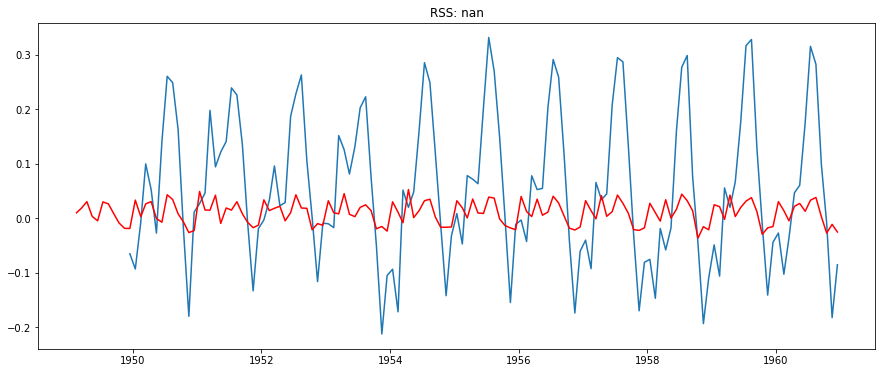

In [ ]:
# Model the time series with ARIMA
model = ARIMA(ts_log, order=(1,1,0))
results_ARIMA = model.fit(disp=-1)

# Plot ARIMA model
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [ ]:
# Model Predictions
# Model results stored as separate series
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

# Starts from 02/1949 and not from the first month because we took a lag by one and the first element does not have anything before to subtract from
# The way to subtract the differences to log scale is to add these differences consecutively to the base number 
# An easier way to do it is to first determine the cumulative sum at index and then add it to the base number

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [ ]:
# Determine the cumulative sum at index
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [ ]:
# Add to the base number by creating a series with all values as the base number and adding the differences to it
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

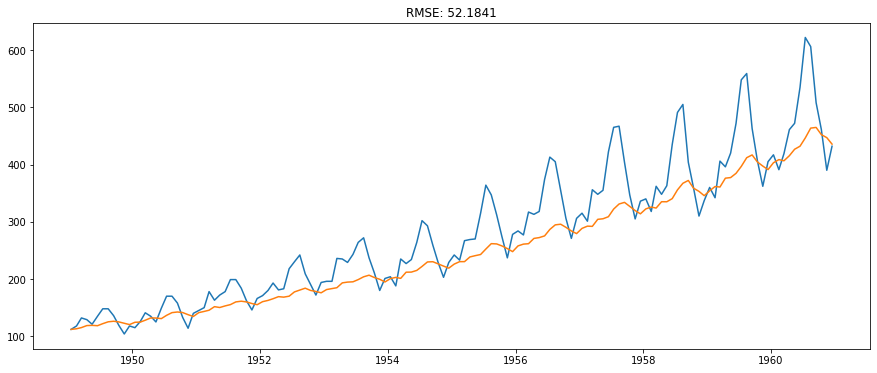

In [ ]:
# Forecast on the original scale
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))

# Captures trend but fails on Seasonality